In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose #library for time series analysis
from statsmodels.tsa.stattools import adfuller


# Load and preprocess the data
df = pd.read_csv("clean_dataset_2019_2022.csv")
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['t_date'] = df['transaction_date'] + pd.offsets.MonthBegin(-1)
df.head()

,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,price,transaction_date,year,month,day_of_week,transaction_year_month,t_date
0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,0.99,2020-10-05,2020,10,0,2020-10,2020-10-01
1,15803,1051516,57266,Loyalist,1 adult with kids,19-24,Produce,national,Vegetables - all others,374,0.70,2020-10-24,2020,10,5,2020-10,2020-10-01
2,15803,967254,57266,Loyalist,1 adult with kids,19-24,Pharmaceutical,national,Cold and flu,374,1.68,2020-10-18,2020,10,6,2020-10,2020-10-01
3,15803,1134222,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Paper housewares,374,2.59,2020-10-23,2020,10,4,2020-10,2020-10-01
4,15803,1003421,57266,Loyalist,1 adult with kids,19-24,Grocery,national,Soup,374,0.60,2020-10-27,2020,10,1,2020-10,2020-10-01


In [2]:
# Filter data and aggregate
# ts = df[df.loyalty == 'Promiscuous'].groupby('t_date').agg(total_revenue=('price', 'sum'))
ts = df.groupby('t_date').agg(total_revenue=('price', 'sum'))

# Train-test split
training = ts[ts.index < '2022-01-01']
test = ts[ts.index >= '2022-01-01']
training = training.asfreq('MS')
test = test.asfreq('MS')

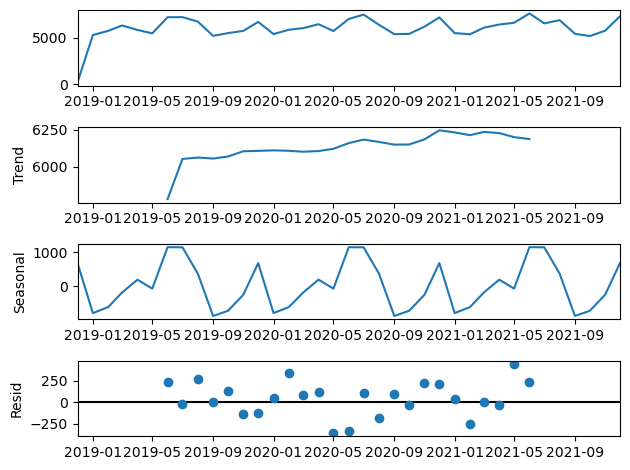

In [3]:
ts_components = seasonal_decompose(training)
ts_components.plot();

In [4]:
# Using mean and variance to check if time series is stationary
split = round(len(training) / 2)
x1 = training[0:split]
x2 = training[split:]
mean1= x1.mean()
mean2= x2.mean()
print("Mean 1 & 2= ", mean1[0], mean2[0])
var1=x1.var()
var2=x2.var()
print("Variance 1 & 2= ",var1[0], var2[0])

Mean 1 & 2=  5673.495 6270.57947368421
Variance 1 & 2=  2222154.3836264703 625648.2613163742


Means are around the same value, but variances seem to be very disperse.

In [5]:
# Test to check that the time series is not defined by a trend, therefore it is a stationaty time series.
# We use the Augmented Dickey-Fuller test
test_adf = adfuller(training)
print('ADF test = ', test_adf[0])
print('p-value = ', test_adf[1])

ADF test =  -3.744109138103427
p-value =  0.003533804485127879


Given that the ADF value is negative and p-value < 0.05, we can reject the null hyphotesis and tell that our time series is stationary. Now we can apply a forecasting method.

In [6]:
# Define history and future for the loop
history = training.copy()
future = test.copy()

# Forecasting loop for ARIMA
forecasts_arima = []
history = training.copy()
for t in range(len(future)):
    model_arima = ARIMA(history, order=(3,0,0), freq='MS')
    model_fit_arima = model_arima.fit()
    yhat_arima = model_fit_arima.forecast(steps=1)[0]
    forecasts_arima.append(yhat_arima)
    # Use concat instead of append
    history = pd.concat([history, future.iloc[[t]]])

# Forecasting loop for SARIMAX
history = training.copy()  # Reset history for SARIMAX
forecasts_sarimax = []
for t in range(len(future)):
    # The SARIMAX model needs a longer time series to estimate seasonal parameters
    # Only proceed with SARIMAX if you have enough data
    # Otherwise, consider using ARIMA or a simpler version of SARIMAX with no seasonal_order
    model_sarimax = SARIMAX(history, order=(3,0,0), seasonal_order=(0, 0, 0, 0), freq='MS')
    model_fit_sarimax = model_sarimax.fit(disp=0)
    yhat_sarimax = model_fit_sarimax.forecast(steps=1)[0]
    forecasts_sarimax.append(yhat_sarimax)
    history = pd.concat([history, future.iloc[[t]]])

# Combine forecasts and actuals into a DataFrame
results_df = pd.DataFrame({
    'Actual': future.squeeze(),
    'Forecast_ARIMA': forecasts_arima,
    'Forecast_SARIMAX': forecasts_sarimax
})

# Ensure that the DataFrame is created outside the loop for both models
results_df_arima = pd.DataFrame({'Actual': test.squeeze(), 'Forecast_ARIMA': forecasts_arima})
results_df_sarimax = pd.DataFrame({'Actual': test.squeeze(), 'Forecast_SARIMAX': forecasts_sarimax})

# Calculate MAE and MAPE for ARIMA
mae_arima = (results_df_arima['Actual'] - results_df_arima['Forecast_ARIMA']).abs().mean()
mape_arima = ((results_df_arima['Actual'] - results_df_arima['Forecast_ARIMA']).abs() / (results_df_arima['Actual'] + 1e-8)).mean() * 100
print(f'ARIMA Mean Absolute Error (MAE): {mae_arima}')
print(f'ARIMA Mean Absolute Percentage Error (MAPE): {round(mape_arima,0)}%')

# Calculate MAE and MAPE for SARIMAX
mae_sarimax = (results_df_sarimax['Actual'] - results_df_sarimax['Forecast_SARIMAX']).abs().mean()
mape_sarimax = ((results_df_sarimax['Actual'] - results_df_sarimax['Forecast_SARIMAX']).abs() / (results_df_sarimax['Actual'] + 1e-8)).mean() * 100
print(f'SARIMAX Mean Absolute Error (MAE): {mae_sarimax}')
print(f'SARIMAX Mean Absolute Percentage Error (MAPE): {round(mape_sarimax,0)}%')

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Mean Absolute Error (MAE): 568.4191933457947
ARIMA Mean Absolute Percentage Error (MAPE): 10.0%
SARIMAX Mean Absolute Error (MAE): 838.4854234440976
SARIMAX Mean Absolute Percentage Error (MAPE): 15.0%


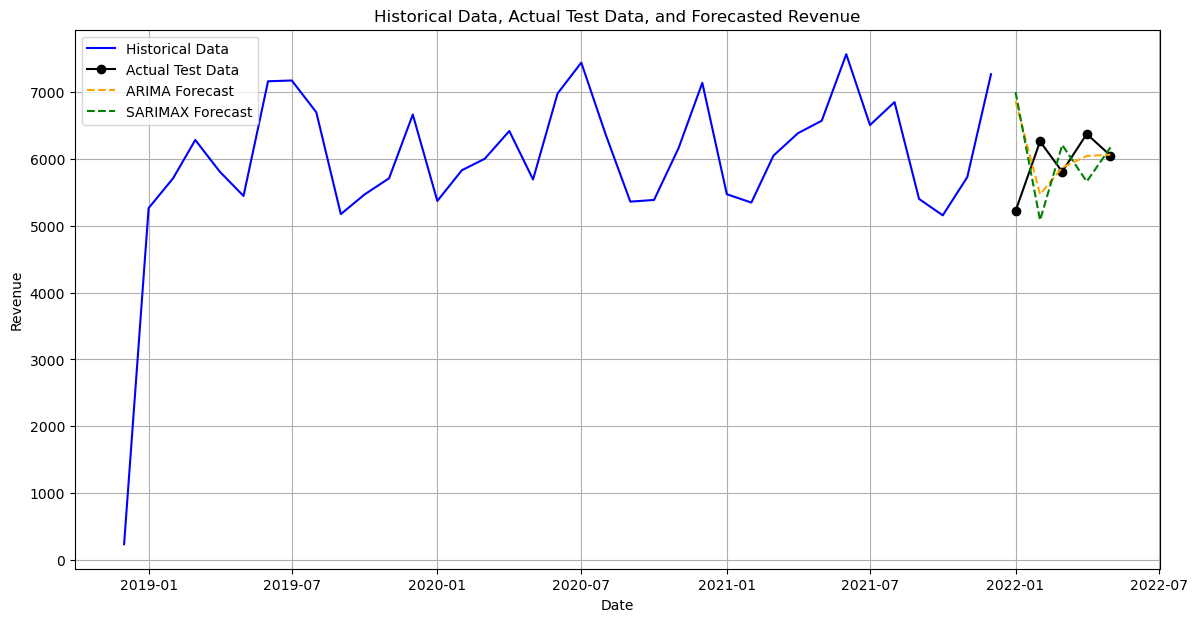

In [7]:
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot historical training data
plt.plot(training, label='Historical Data', color='blue')

# Plot actual test data
plt.plot(test, label='Actual Test Data', color='black', linestyle='-', marker='o')

# Plot ARIMA forecast
plt.plot(test.index, results_df_arima['Forecast_ARIMA'], label='ARIMA Forecast', color='orange', linestyle='--')

# Plot SARIMAX forecast
plt.plot(test.index, results_df_sarimax['Forecast_SARIMAX'], label='SARIMAX Forecast', color='green', linestyle='--')

# Adding titles and labels
plt.title('Historical Data, Actual Test Data, and Forecasted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


From the Error metrics differentiation, we can conclude that both models are almost identical. So, we select SARIMAX to predict 2 years later revenue.

In [8]:
history = ts.asfreq('MS')

# Define the SARIMAX model - adjust the order and seasonal_order as per your data
model_SARIMAX = SARIMAX(history, order=(3,0,0), seasonal_order=(1,1,1,12), freq='MS')
model_ARIMA = ARIMA(history, order=(3,0,0), freq='MS')
# Fit the model
model_fit_SARIMAX = model_SARIMAX.fit(disp=0)
model_fit_ARIMA = model_ARIMA.fit()

C:\Users\pc\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\pc\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# Change this line to model_fit_SARIMAX in order to change the outputs and the chart
model_fit = model_fit_SARIMAX

In [10]:
# Calculate the number of steps to forecast
forecast_steps = 24

# Generate forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean

# The predicted revenue for each future month is now in 'predicted_mean'
# The last value corresponds to 2025-06-01
predicted_revenue_2025_06 = predicted_mean[-1]

print(f"The predicted revenue for 2025-06-01 is: {predicted_revenue_2025_06}")

# Calculate the average predicted revenue for the forecast period
average_predicted_revenue = predicted_mean.mean()

print(f"The average predicted revenue from 2023-06-01 to 2025-06-01 is: {average_predicted_revenue}")


The predicted revenue for 2025-06-01 is: 5516.787681570213
The average predicted revenue from 2023-06-01 to 2025-06-01 is: 5893.816199149925


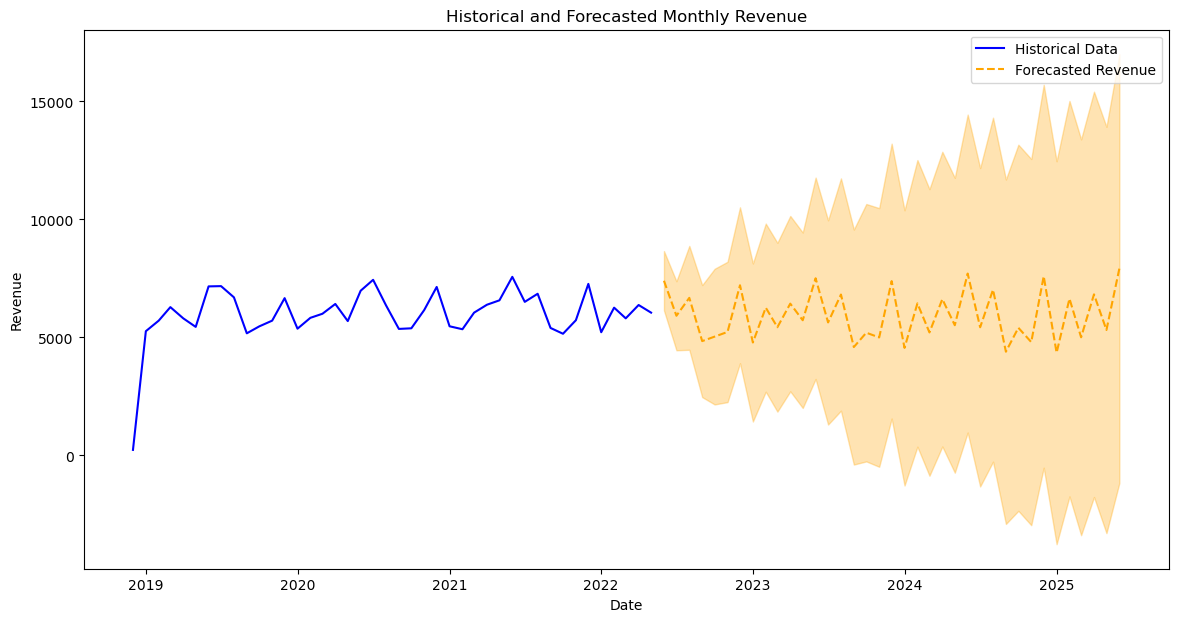

In [11]:
from pandas.tseries.offsets import DateOffset

# Assuming 'history' contains all the data up to 2023-06-01
# If not, make sure to include all data up to this point
last_date = history.index[-1]
start_date = last_date + DateOffset(months=1)
end_date = '2025-06-01'

# Calculate the number of steps to forecast from the last date of historical data
forecast_steps = pd.date_range(start=start_date, end=end_date, freq='MS').shape[0]

# Generate forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
predicted_mean = forecast.predicted_mean
predicted_conf_int = forecast.conf_int()

# Create a date range for the forecast
forecast_dates = pd.date_range(start=start_date, periods=forecast_steps, freq='MS')

# Plotting the historical and forecasted revenue
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(history.index, history, label='Historical Data', color='blue')

# Plot the forecasted data
plt.plot(forecast_dates, predicted_mean, label='Forecasted Revenue', color='orange', linestyle='--')

# Plot the confidence intervals
plt.fill_between(forecast_dates, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='orange', alpha=0.3)

# Add titles and labels
plt.title('Historical and Forecasted Monthly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()

# Show the plot
plt.show()
